In [2]:
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np


c:\Users\joroc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Util functions

def gaussian_distribution_density_data(mu, sigma):
    """
        Given a mu and a sigma, this function returns a tuple representing the X and Y of the PDF

        params: mu, sigma <numbers>
        return: X, Y of the normal distribution()
    """
    data = torch.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    gaussian_distribution = (1/(sigma * torch.sqrt(torch.tensor(2) * torch.pi))) * torch.exp(-0.5 * ((data - mu) / sigma)**2)
    return data, gaussian_distribution

def plot(X, mu1, sigma1, mu2, sigma2, title=''):
    # a) Scatter Plot with histograms
    # Histograms
    plt.hist(X, bins=50, alpha=0.25, density = True, histtype='bar', ec='black')
    # Scatter
    plt.scatter(X,torch.zeros(len(X)))
    # Density
    x1, gaussian_density_1 = gaussian_distribution_density_data(mu1, sigma1)
    x2, gaussian_density_2 = gaussian_distribution_density_data(mu2, sigma2)
    plt.plot(x1, gaussian_density_1, label=f'Gaussian (mu={mu1}, sigma={sigma1})', color='red')
    plt.plot(x2, gaussian_density_2, label=f'Gaussian (mu={mu2}, sigma={sigma2})', color='blue')
    if len(title):
        plt.title(title)
    plt.legend()
    plt.show()


# Trabajo Práctico 0: Algoritmo de Maximización de la Esperanza

X =  tensor([ 3.8880, 13.0166,  6.6521,  9.3187, 13.4357, 11.3862, 14.5502,  5.1571,
        10.9688,  6.5539,  7.0504,  7.5831, 10.7786,  7.9441,  6.2217, 10.1352,
        10.7265,  9.5961, 10.1464, 11.1300, 30.7356, 30.5071, 30.7836, 27.2629,
        30.6974, 26.5891, 30.8522, 28.8525, 28.7032, 26.8235, 31.0348, 28.1722,
        26.0353, 31.3528, 31.6588, 33.4433, 31.7198, 31.7060, 26.6493, 28.5370])


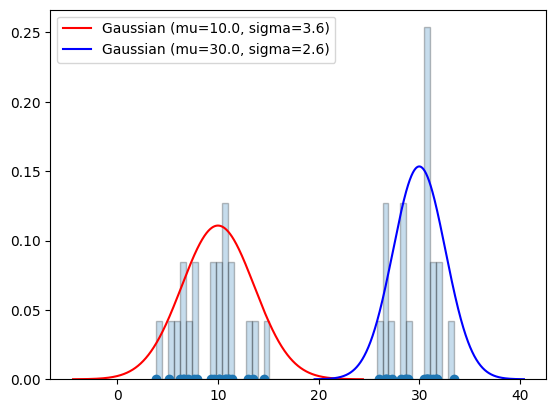

In [4]:
n = 20
mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

# 1)
# Generates data that follows two 2gaussian distributions based on a set of parameters.
def generate_data(n, mu1, sigma1, mu2, sigma2):

  # Generate distributions
  normal_dist1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
  normal_dist2 = torch.distributions.Normal(torch.tensor([mu2]), torch.tensor([sigma2]))

  # Take a sample from each dist
  gaussian_sample1 = normal_dist1.sample((n,1)).squeeze()
  gaussian_sample2 = normal_dist2.sample((n,1)).squeeze()

  # Concatenate the 2 samples
  X =  torch.cat((gaussian_sample1, gaussian_sample2))
  return X

X = generate_data(n, mu1, sigma1, mu2, sigma2)
print('X = ', X)

plot(X, mu1, sigma1, mu2, sigma2)



In [5]:
# 2)
def init_random_parameters(k=2, range=50):
  """
      Generates randombly mu and sigma parameters
      params: k, range
      return: A Kx2 matrix where colum 0 corresponds to mu and column 1 to sigma
  """
  return torch.rand((k, 2))*range

P = init_random_parameters()
print('P = ', P)

P =  tensor([[10.9610, 33.5316],
        [48.1054,  3.1710]])


In [6]:
# 3)
def calculate_log_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
  # Nota: tal vez deberíamos poner en el latex el proceso desde la función de likelihood sin log hasta esta versión
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)

likelihood_test = calculate_log_likelihood_gaussian_observation(X[0], mu1, sigma1)
print('likelihood_test = ', likelihood_test)

likelihood_test =  tensor(-3.6411)


In [7]:
# 4)
def calculate_membership_dataset(X_dataset, Parameters_matrix, k=2):
  N = len(X_dataset)
  #print(N)
  M = torch.zeros(N, k)

  # for each element in X, calculate its likelyhood with each set of parameters from the Parameter Matrix and store the maximum
  for x in range(N):
    # set max likelyhood initially as a very low number (Me suena que esto también podría ponerse de una mejor forma)
    x_max_likelyhood = -999999999
    k_membership = 0
    # iterate over the parameter sets to find which set achieves max likelihood over x
    for k_index, parameters in enumerate(Parameters_matrix):
      #print('Debug: x = ', X_dataset[x], 'params = ', parameters[0], parameters[1])
      x_likelyhood = calculate_log_likelihood_gaussian_observation(X_dataset[x], parameters[0], parameters[1])
      #print('Debug: x_likelyhood = ', x_likelyhood)
      if x_likelyhood > x_max_likelyhood:
        x_max_likelyhood = x_likelyhood
        #print('Debug: max likelyhood = ', x_max_likelyhood)
        k_membership = k_index
    M[x][k_membership] = 1

  return M

M = calculate_membership_dataset(X, P)
print('M = ', M)

M =  tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


C:\Users\joroc\AppData\Local\Temp\ipykernel_22392\1441229646.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


In [8]:
#5)

def recalculate_parameters(X_dataset, Membership_data):
    # TODO: Can we improve this to use torch?
    membership_k1 = Membership_data[:,0]
    membership_k2 = Membership_data[:,1]
    k1_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k1[index] == 1])
    k2_tentative_values = torch.tensor([x for index, x in enumerate(X_dataset) if membership_k2[index] == 1])
    mu_1 = torch.mean(k1_tentative_values)
    mu_2 = torch.mean(k2_tentative_values)
    sigma_1 = torch.std(k1_tentative_values)
    sigma_2 = torch.std(k2_tentative_values)
    return torch.tensor([[mu_1, sigma_1],[mu_2, sigma_2]])

print('Real parameters k1=[{},{}], k2=[{},{}] '.format(mu1, sigma1, mu2, sigma2))
print('Old P parameters: ', P)
P = recalculate_parameters(X, M)
print('New P parameters: ', P)

Real parameters k1=[10.0,3.6], k2=[30.0,2.6] 
Old P parameters:  tensor([[10.9610, 33.5316],
        [48.1054,  3.1710]])
New P parameters:  tensor([[19.4589, 10.5745],
        [    nan,     nan]])


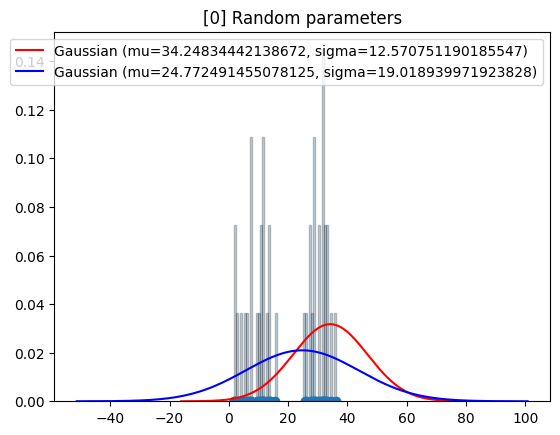

C:\Users\joroc\AppData\Local\Temp\ipykernel_22392\1441229646.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


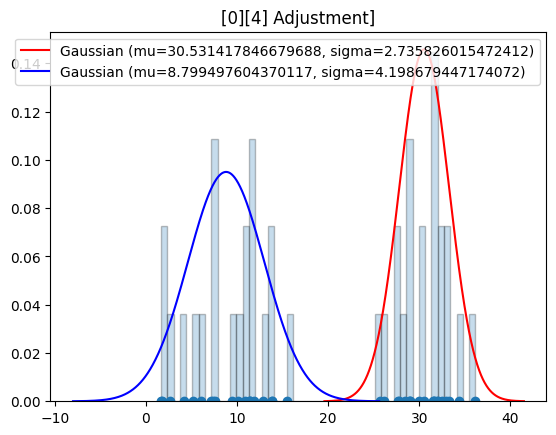

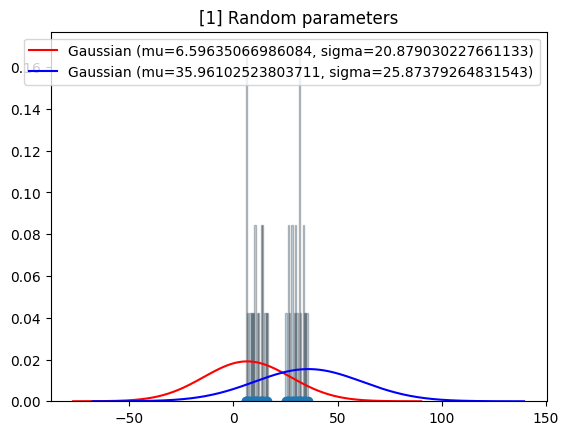

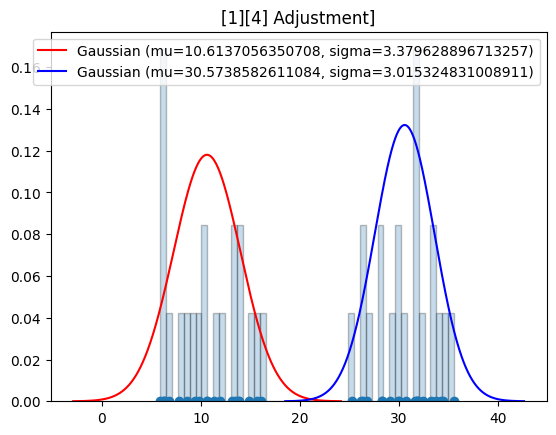

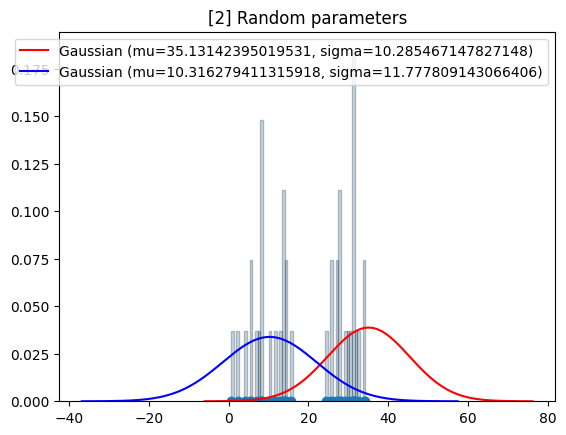

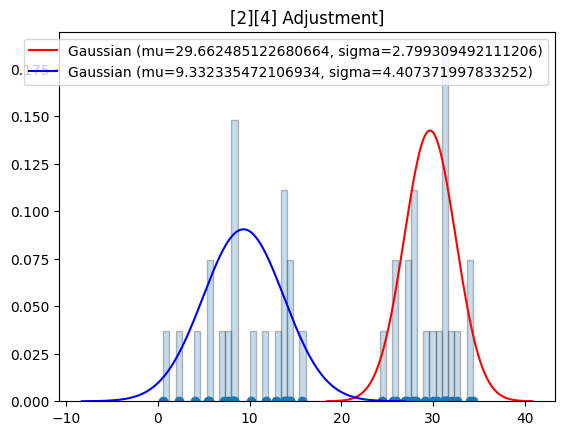

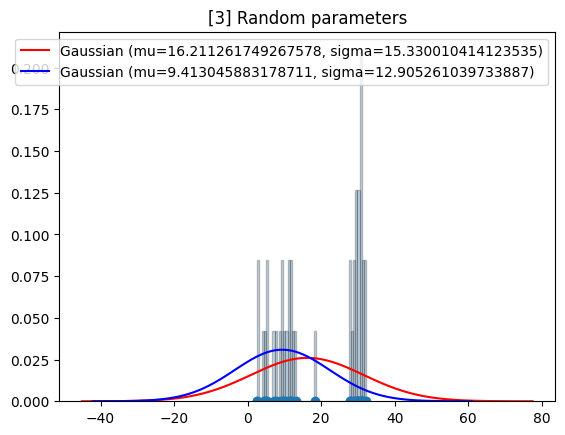

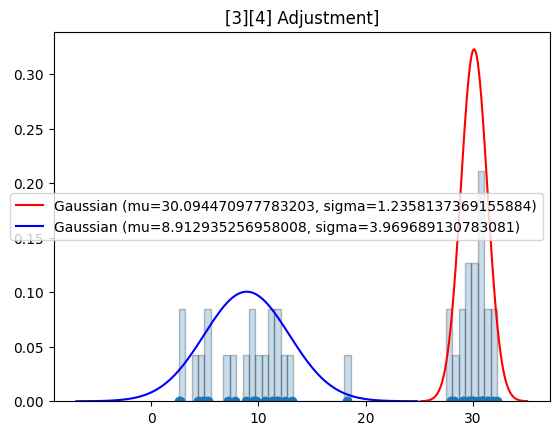

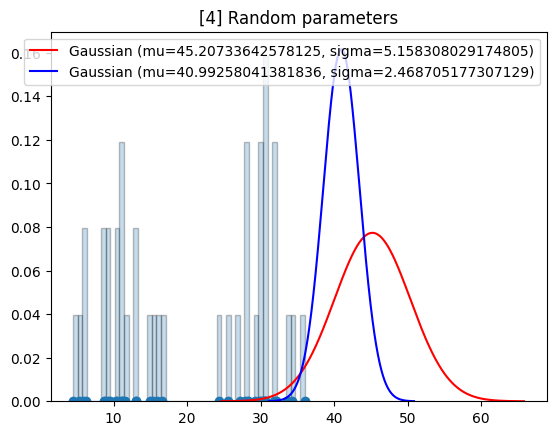

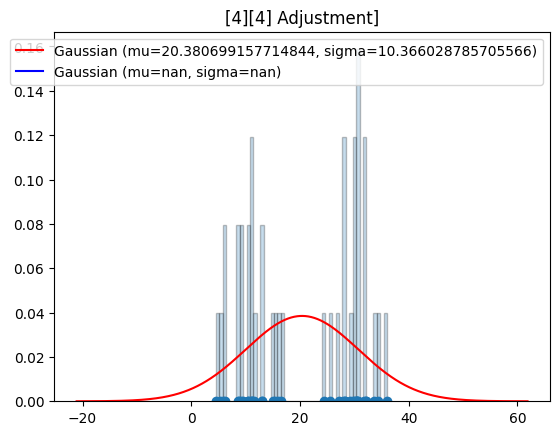

In [9]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = init_random_parameters()
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))

In [56]:
# 7)
def random_parameters_heuristic(X):
    mu = torch.mean(X, dim=0)
    sigma = torch.std(X, dim=0)
    mu_below = mu - sigma
    mu_above = mu + sigma
    mu1 = (mu - mu_below) * torch.rand(1) + mu_below
    sigma1 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    mu2 = (mu_above - mu) * torch.rand(1) + mu
    sigma2 = (sigma / 2 - sigma / 4) * torch.rand(1) + sigma / 4
    return torch.tensor([[mu1, sigma1], [mu2, sigma2]])



PI = random_parameters_heuristic(X)
print(PI)    

tensor([[16.9013,  3.9417],
        [21.0499,  4.3185]])


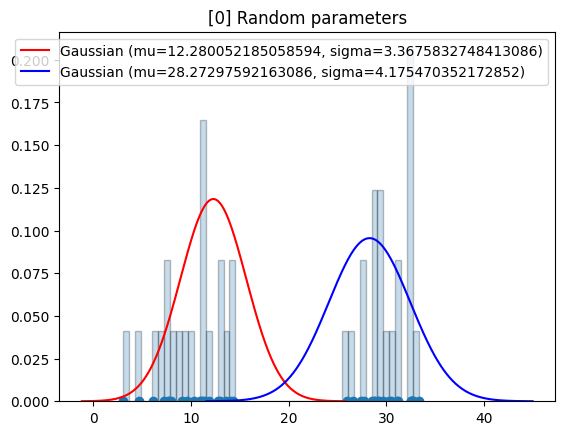

C:\Users\joroc\AppData\Local\Temp\ipykernel_22392\1441229646.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -(1 / 2) * torch.log(torch.tensor(2 * torch.pi)) - 1 * torch.log(torch.tensor(sigma_k)) - (1 / (2 * sigma_k**2)) * torch.sum((x_n - mu_k) ** 2)


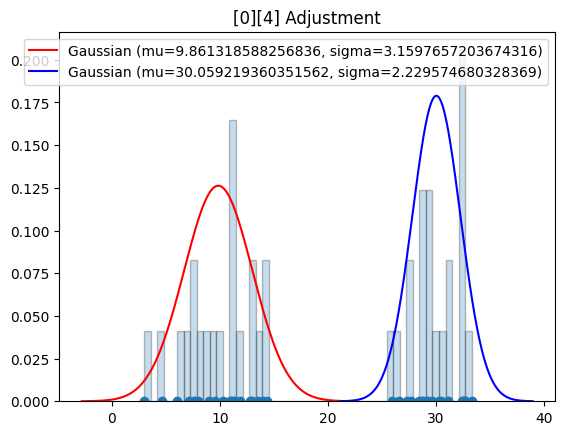

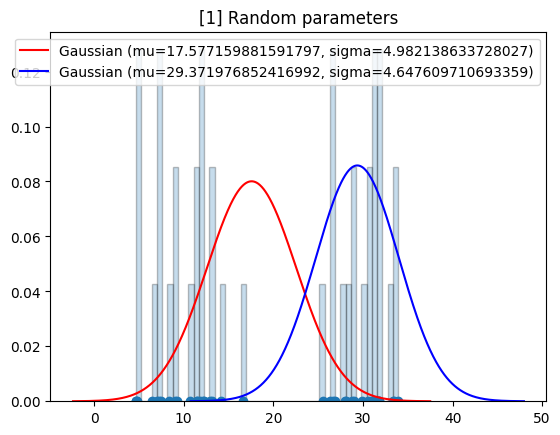

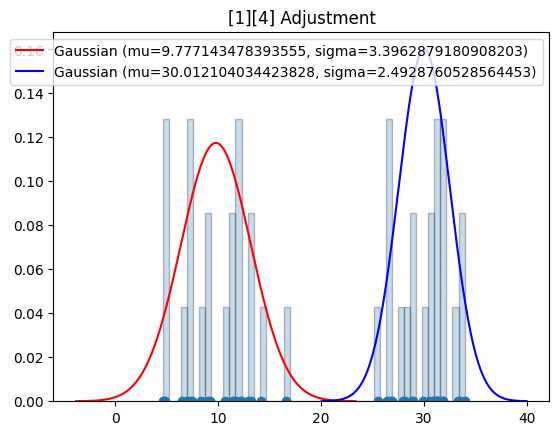

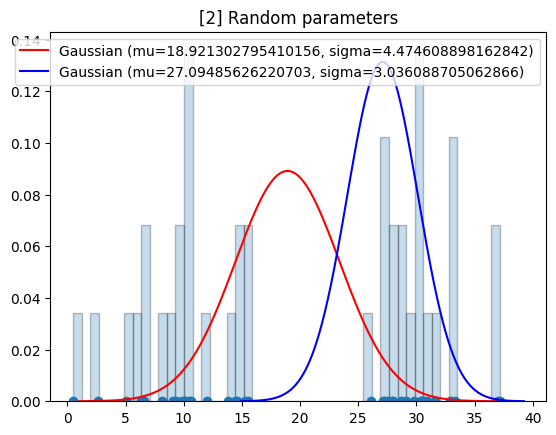

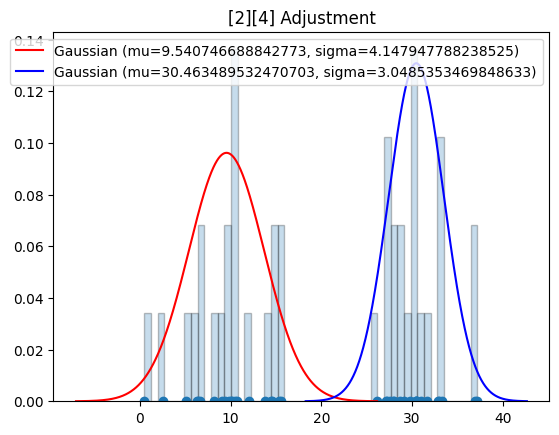

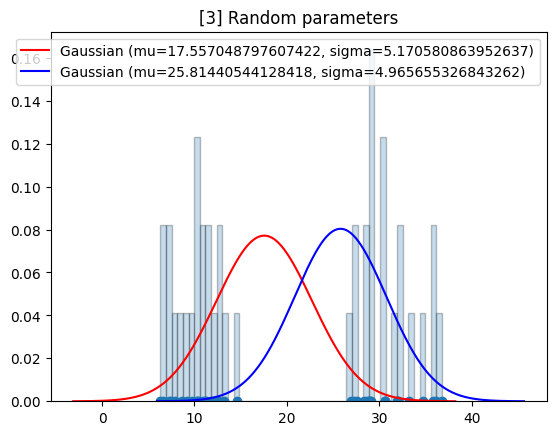

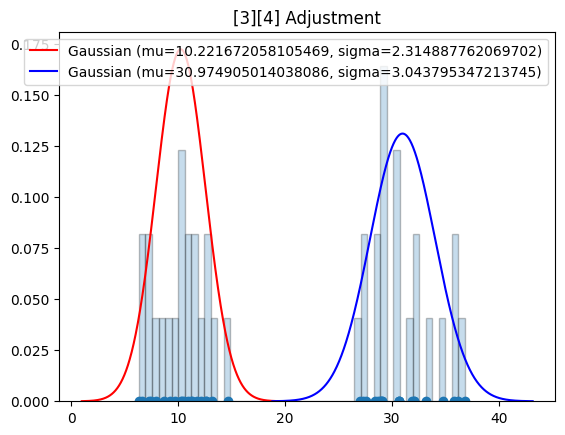

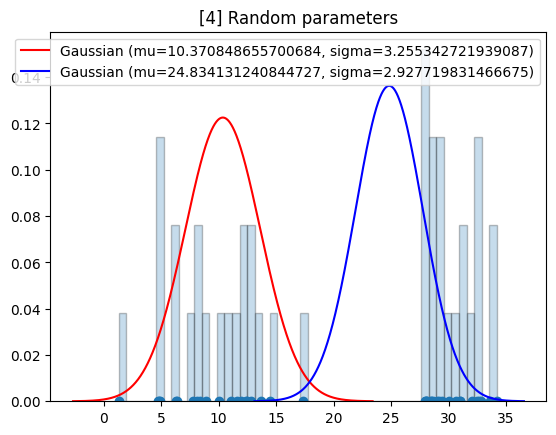

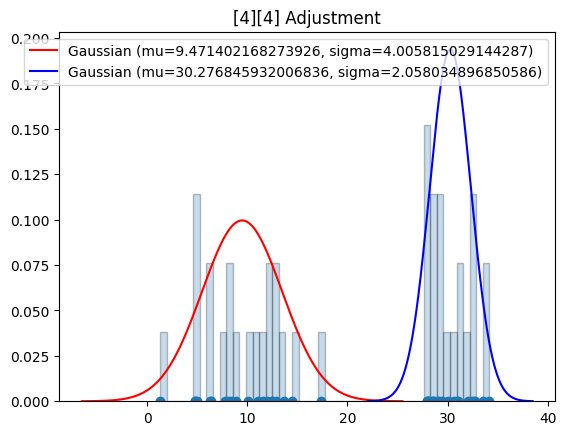

In [58]:
i_max = 5
i_adj_max = 5

mu1 = 10.0
sigma1 = 3.6
mu2 = 30.0
sigma2 = 2.6

for i in range(i_max):
    X = generate_data(n, mu1, sigma1, mu2, sigma2)
    P = random_parameters_heuristic(X)
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}] Random parameters'.format(i))

    for a in range(i_adj_max):
        M = calculate_membership_dataset(X, P)

        #print('[', i,'] Old P parameters: ', P)
        P = recalculate_parameters(X, M)
        #print('[', i,'] New P parameters: ', P, '\n')
    plot(X, P[0][0], P[0][1], P[1][0], P[1][1], '[{}][{}] Adjustment'.format(i, a))